In [2]:
import os
import pandas as pd
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import zipfile
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, Rescaling
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from keras import Input

In [3]:
DATA_DIR = '/kaggle/input/oral-diseases/unprocessed'
categories = ['calculus', 'caries', 'gingivitis', 'hypodontia', 'tooth_discoloration', 'ulcer']

# Define directories for train, validation, and test splits
base_dir = '/kaggle/working/dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Create the train, validation, and test directories with subdirectories for each category
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Split each category
for category in categories:
    category_dir = os.path.join(DATA_DIR, category)
    filenames = os.listdir(category_dir)
    # Split the dataset into train, val, and test sets (e.g., 80% train, 10% validation, 10% test)
    train_filenames, temp_filenames = train_test_split(filenames, test_size=0.2, random_state=42)
    val_filenames, test_filenames = train_test_split(temp_filenames, test_size=0.5, random_state=42)

    for filename in train_filenames:
        shutil.copy(os.path.join(category_dir, filename), os.path.join(train_dir, category, filename))
    for filename in val_filenames:
        shutil.copy(os.path.join(category_dir, filename), os.path.join(val_dir, category, filename))
    for filename in test_filenames:
        shutil.copy(os.path.join(category_dir, filename), os.path.join(test_dir, category, filename))

print("Data split completed!")

Data split completed!


In [4]:
# Set parameters
DIMX, DIMY = 224, 224  # Image dimensions
HIDDEN = 128           # Number of hidden units in dense layer
OUTPUT_CLASSES = 6     # Number of output classes
BATCH_SIZE = 32
INITIAL_LEARNING_RATE = 0.001
NUM_FINETUNE_EPOCHS = 10

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(DIMX, DIMY),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
val_generator = val_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(DIMX, DIMY),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(DIMX, DIMY),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)


Found 9319 images belonging to 6 classes.
Found 1165 images belonging to 6 classes.
Found 1169 images belonging to 6 classes.


In [5]:
print("Classes detected:", train_generator.class_indices)

Classes detected: {'calculus': 0, 'caries': 1, 'gingivitis': 2, 'hypodontia': 3, 'tooth_discoloration': 4, 'ulcer': 5}


In [6]:
# Directories for train, val, and test splits
split_directories = {'train': train_dir, 'val': val_dir, 'test': test_dir}

# Count and print the number of images in each category for each split
category_counts = {category: {'train': 0, 'val': 0, 'test': 0} for category in categories}

for split, split_dir in split_directories.items():
    for category in categories:
        category_dir = os.path.join(split_dir, category)
        num_files = len(os.listdir(category_dir))
        category_counts[category][split] = num_files

# Print the total dataset count for each category
for category in categories:
    total_files = sum(category_counts[category].values())
    print(f"Category '{category}': Total files = {total_files}")
    print(f"  Train: {category_counts[category]['train']}")
    print(f"  Validation: {category_counts[category]['val']}")
    print(f"  Test: {category_counts[category]['test']}")


Category 'calculus': Total files = 1296
  Train: 1036
  Validation: 130
  Test: 130
Category 'caries': Total files = 2382
  Train: 1905
  Validation: 238
  Test: 239
Category 'gingivitis': Total files = 2349
  Train: 1879
  Validation: 235
  Test: 235
Category 'hypodontia': Total files = 1251
  Train: 1000
  Validation: 125
  Test: 126
Category 'tooth_discoloration': Total files = 1834
  Train: 1467
  Validation: 183
  Test: 184
Category 'ulcer': Total files = 2541
  Train: 2032
  Validation: 254
  Test: 255


In [7]:
def build_model(output_classes, learning_rate):
    base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(DIMX, DIMY, 3))
    base_model.trainable = False  # Freeze base model

    inputs = Input(shape=(DIMX, DIMY, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(HIDDEN, activation="relu")(x)
    outputs = Dense(output_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model
    
# Unfreeze layers and recompile model
def unfreeze_base_layers(model, layers, learning_rate):
    base_model = model.layers[1]  # Base model is the second layer
    for layer in base_model.layers[-layers:]:
        layer.trainable = True
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Training the model with gradual fine-tuning
model = build_model(OUTPUT_CLASSES, INITIAL_LEARNING_RATE)
# Callbacks
tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)
early_stopping = EarlyStopping(monitor="val_loss", patience=3)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Step 1: Train only top layers
history_step1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_FINETUNE_EPOCHS,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734074467.364958     161 service.cc:145] XLA service 0x7a2cf00027e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734074467.365019     161 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734074467.365023     161 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734074472.993671     161 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


291/292 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6614 - loss: 0.8712

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


292/292 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.6620 - loss: 0.8696 - val_accuracy: 0.8017 - val_loss: 0.4928
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8468 - loss: 0.3799 - val_accuracy: 0.8541 - val_loss: 0.3488
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8890 - loss: 0.2670 - val_accuracy: 0.8687 - val_loss: 0.3370
Epoch 4/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.9126 - loss: 0.2279 - val_accuracy: 0.8953 - val_loss: 0.2531
Epoch 5/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9227 - loss: 0.1842 - val_accuracy: 0.8738 - val_loss: 0.3026
Epoch 6/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.9293 - loss: 0.1656 - val_accuracy: 0.9064 - val_loss: 0.2316
Epoch 7/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9363 - loss: 0.1464 - val_accuracy: 0.8953 - val_loss: 0.2651
Epoch 8/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.9433 - loss: 0.1277 - val_accurac

In [9]:
# Evaluate after step 1
loss, accuracy = model.evaluate(test_generator)
print(f"Step 1 - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.8910 - loss: 0.2338
Step 1 - Loss: 0.2611, Accuracy: 0.8896


In [10]:
# Step 2: Fine-tune more layers
UNFREEZE_LAYERS = 20  # Number of layers to unfreeze in each step
learning_rate = INITIAL_LEARNING_RATE / 10  # Reduce learning rate
model = unfreeze_base_layers(model, layers=UNFREEZE_LAYERS, learning_rate=learning_rate)

history_step2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_FINETUNE_EPOCHS,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 38s 92ms/step - accuracy: 0.8249 - loss: 0.4808 - val_accuracy: 0.8455 - val_loss: 0.5730
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.9340 - loss: 0.1403 - val_accuracy: 0.8807 - val_loss: 0.4155
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.9470 - loss: 0.1132 - val_accuracy: 0.9193 - val_loss: 0.2315


In [11]:
# Evaluate after step 2
loss, accuracy = model.evaluate(test_generator)
print(f"Step 2 - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8961 - loss: 0.2330
Step 2 - Loss: 0.2637, Accuracy: 0.8931


In [12]:
# Step 3: Fine-tune deeper layers
UNFREEZE_LAYERS += 20  # Unfreeze more layers
learning_rate /= 2  # Further reduce learning rate
model = unfreeze_base_layers(model, layers=UNFREEZE_LAYERS, learning_rate=learning_rate)

history_step3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=NUM_FINETUNE_EPOCHS,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.9124 - loss: 0.2017 - val_accuracy: 0.9107 - val_loss: 0.2756
Epoch 2/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.9427 - loss: 0.1257 - val_accuracy: 0.9142 - val_loss: 0.2298
Epoch 3/10
292/292 ━━━━━━━━━━━━━━━━━━━━ 20s 69ms/step - accuracy: 0.9461 - loss: 0.1108 - val_accuracy: 0.9116 - val_loss: 0.2263


In [13]:
# Evaluate after step 3
loss, accuracy = model.evaluate(test_generator)
print(f"Step 3 - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8811 - loss: 0.2807
Step 3 - Loss: 0.2382, Accuracy: 0.8982


Plot saved as Mouth_Ulcer_0_4996.jpeg


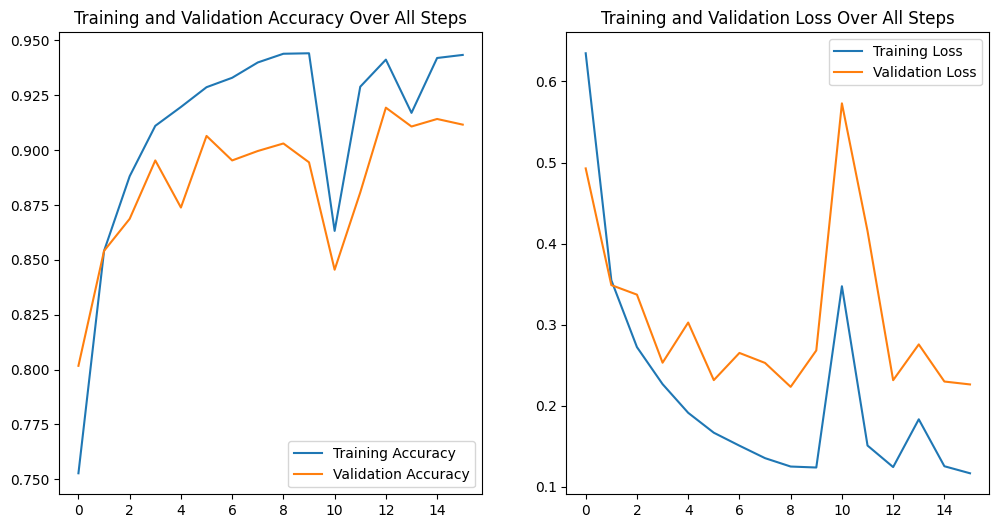

In [14]:
# Function to combine histories from multiple steps
def combine_histories(histories):
    combined_history = {
        'accuracy': [],
        'val_accuracy': [],
        'loss': [],
        'val_loss': []
    }
    
    for history in histories:
        combined_history['accuracy'].extend(history.history['accuracy'])
        combined_history['val_accuracy'].extend(history.history['val_accuracy'])
        combined_history['loss'].extend(history.history['loss'])
        combined_history['val_loss'].extend(history.history['val_loss'])
    
    return combined_history

# Function to plot combined training and validation accuracy and loss
def plot_combined_history(combined_history, total_epochs):
    # Get the combined accuracy and loss values
    acc = combined_history['accuracy']
    val_acc = combined_history['val_accuracy']
    loss = combined_history['loss']
    val_loss = combined_history['val_loss']
    
    # Create epochs range for plotting
    epochs_range = range(total_epochs)
    
    # Plot Accuracy
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over All Steps')
    plt.legend(loc='lower right')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over All Steps')
    plt.legend(loc='upper right')

    plt.savefig(filename, format='png')  # Save as PNG format
    print(f"Plot saved as {filename}")
    
    # Show the plots
    plt.show()

# Combine the histories from all steps
combined_history = combine_histories([history_step1, history_step2, history_step3])

# Calculate the total number of epochs
total_epochs = len(combined_history['accuracy'])

# Plot the combined history
plot_combined_history(combined_history, total_epochs)


In [15]:
# Save final model
model.save("fine_tuned_model.h5")